In [1]:
using Pkg
Pkg.activate("../..")

  Activating project at `~/Documents/repos/nanoOpt.jl`


In [2]:
using Measures,LinearAlgebra,LazyGrids,LaTeXStrings,QuadGK,Plots

In [3]:
include("../../src/NanoOpt.jl")

KsspSlab (generic function with 1 method)

In [4]:
mat1 = material(1.0^2,1.0)
matSc = material(epstable("gold"),1.0)
mat2 = material(1.45^2,1.0);

In [5]:
matScatter = [mat1; matSc];

In [6]:
layer = layerstructure([mat1,mat2],[0.0,],"up");

In [7]:
w,d = 50.,17.
rc = 2.
Nc,Nw,Nd = 3,25,5
xC = (-1.1,d/2. +0.);

In [8]:
rod = Rod(w,d,rc,Nc,Nw,Nd,xC);

In [9]:
xmin,ymin = -90.0,-90.0
xmax,ymax = 90.0,90.0
Δx,Δy = 15.,16.6

xA = collect(xmin:Δx:xmax)
yA = collect(ymin:Δy:ymax)
Xin,Xout,Yin,Yout = getMesh(xA,yA,rod);

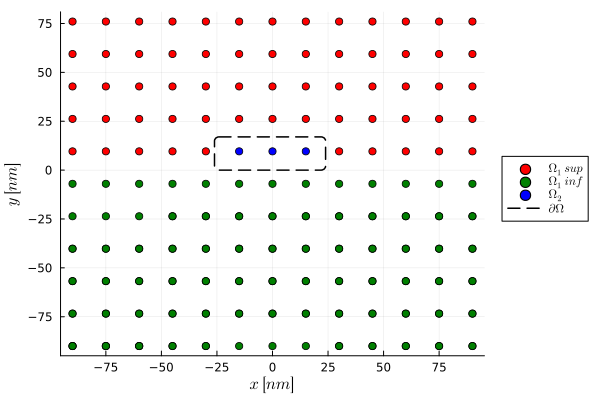

In [10]:
gr()
X,Y = getSurfPoints(rod)

Yop = Yout[findall(Yout .≥ 0.)]
Xop = Xout[findall(Yout .≥ 0.)]
Yom = Yout[findall(Yout .≤ 0.)]
Xom = Xout[findall(Yout .≤ 0.)]

scatter(Xop,Yop,c=:red,label=L"\Omega_1~sup")
scatter!(Xout,Yom,c=:green,label=L"\Omega_1~inf")
scatter!(Xin,Yin,c=:blue,label=L"\Omega_2")
plot!(X,Y,c=:black,lw=1.5,ls=:dash,label=L"\partial \Omega",xlabel=L"x~[nm]",ylabel=L"y~[nm]",legend=:outerright)

In [11]:
#plotly()
#scatter(Xop,Yop,c=:red,label="")
#scatter!(Xout,Yom,c=:green,label="")
#scatter!(Xin,Yin,c=:blue,label="")
#plot!(X,Y,c=:black,lw=1.5,ls=:dash,label="")

In [12]:
length(Xout)

140

In [13]:
xm = (maximum(X)-minimum(X))+1;

In [14]:
yp = 2maximum(Y)+2
ym = 2minimum(Y);

In [15]:
yp

36.0

In [16]:
dThr = 50.
m = 2

2

In [17]:
i = 1

k0 = 2π/555
n₁ = mat1.n(k0)
n₂ = mat2.n(k0)
r = 500.
α = 30.

30.0

In [18]:
SParms = SommerfieldParams(layer,3k0,9e-3);

In [19]:
@time Grf = GreenFunctions(matScatter,"layer";xP= (xm , 12), yP = (ym,yp,12), SParms = SParms);

 14.181269 seconds (38.10 M allocations: 1.736 GiB, 5.07% gc time, 64.19% compilation time)


In [20]:
@time H,ϕ = getHϕ(m,rod,k0,Grf,matSc.n,mat1.n,dThr,α,layer,"layer");

 30.207702 seconds (193.89 M allocations: 8.870 GiB, 9.29% gc time, 44.00% compilation time)


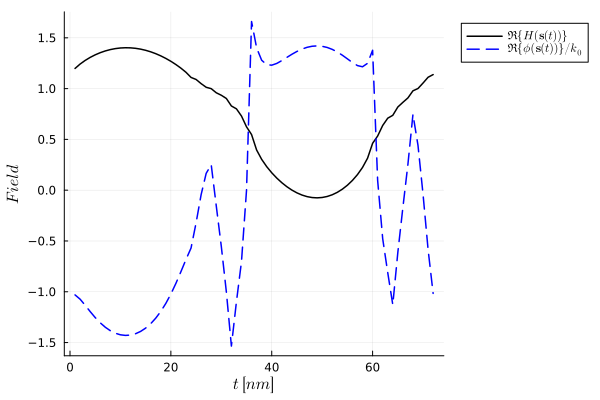

In [21]:
gr()
plot(real.(H[:,3]),c=:black,lw=1.5,label=L"\Re\{ H(\mathbf{s}(t)) \}")
plot!(real.(ϕ[:,3])./k0,c=:blue,lw=1.5,ls=:dash,label=L"\Re\{ \phi(\mathbf{s}(t)) \}/ k_0",xlabel=L"t~[nm]",ylabel=L"Field",legend=:outertopright)

# ================================================================

In [22]:
SParmsF = SommerfieldParams(layer,3k0,9e-3);

In [23]:
@time HIn = getHfieldInside(k0,matSc,m,dThr,rod,Xin,Yin,α,H,ϕ);

  0.772023 seconds (3.00 M allocations: 122.023 MiB, 5.27% gc time, 249.17% compilation time)


In [24]:
@time HOup = getHfielOutsie(k0,SParmsF,m,dThr,rod,Xout,Yout,α,H,ϕ);

476.234680 seconds (8.57 G allocations: 389.945 GiB, 22.61% gc time, 111.32% compilation time)


In [25]:
grd = [Xout Yout abs.(HOup);
        Xin Yin abs.(HIn)];


In [26]:
ind = sortperm(grd[:,2])

ogrd = grd[ind,:]


ind2 = sortperm(ogrd[:,1])

ogrd2 = ogrd[ind2,:];

In [27]:
imagenH = reshape(ogrd2[:,3],(length(yA),length(xA)));

In [28]:
plotly()
surface(xA,yA,imagenH)

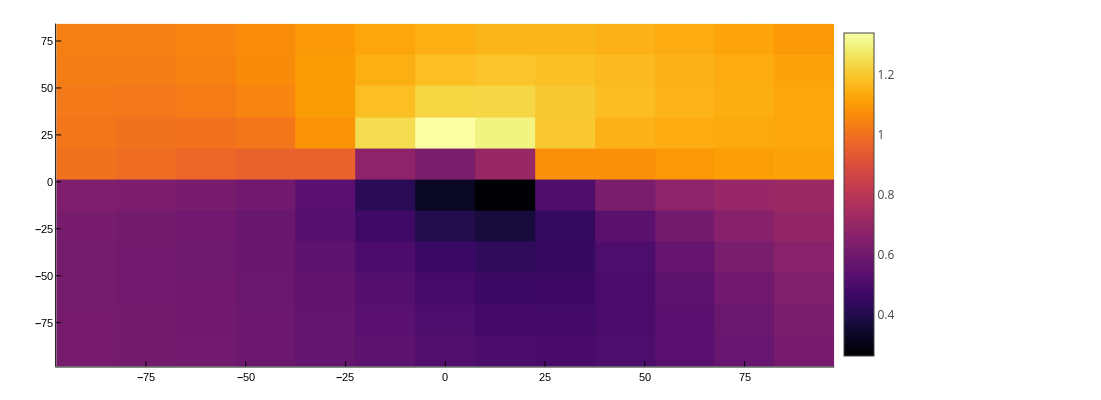

In [29]:
heatmap(xA,yA,imagenH)

In [30]:
function testEins(k₀::Number,SParms::SommerfieldParams,m::Int64,dThr::Number,Str::Structure,Xout::Vector{Float64},Yout::Vector{Float64},α::Number,H::Matrix{ComplexF64},ϕ::Matrix{ComplexF64})
    μ₀ = 1.25663706144e-6
    ε₀ = 8.85418781762e-12
    
    layer = SParms.layer
    n₁ = layer.mat[1].n(k₀)
    E₀Arr = Get_E0(k₀,layer,Xout,Yout,α)
    #E₀Arr = E₀Arr./maximum(norm.(E₀Arr))
    posOut = [Xout Yout]

    ω = k₀/√(μ₀*ε₀)

    Eout = Array{Array{ComplexF64,1}}(undef,size(posOut,1))

    @threads for p ∈ axes(posOut,1)
        pos = posOut[p,:]
        opt = pos[2] ≤ 0 ? "down" : "up"
        Eout[p] = (im/(ω*ε₀*n₁^2))*Eins(k₀,pos,SParms,m,Str,H,ϕ,opt)
        #Eout[p] = E₀Arr[p].+ (im/(ω*ε₀*n₁^2))*getIntegralScatterEf(k₀,layer,m,pos,Str,H,ϕ)
    end
    Eout
end

testEins (generic function with 1 method)

In [31]:
μ₀ = 1.25663706144e-6
ε₀ = 8.85418781762e-12


c1 = √(μ₀/ε₀)*(1/n₁)
c2 = √(μ₀/ε₀)*(1/matSc.n(k0))
c2 = abs(c2)

147.6113251035512

In [32]:
@time Eout = getEfieldOutside(k0,SParmsF,m,dThr,rod,Xout,Yout,α,H,ϕ);

333.989549 seconds (8.37 G allocations: 380.301 GiB, 30.98% gc time, 6.27% compilation time)


In [33]:
@time Ein = getEfieldInside(k0,matSc.n(k0),m,dThr,rod,Xin,Yin,α,H,ϕ);

  1.591421 seconds (1.78 M allocations: 81.820 MiB, 3.95% gc time, 350.44% compilation time)


In [34]:
eff = [Xout Yout norm.(Eout)./c1;
        Xin Yin norm.(Ein)./c2];

In [35]:
ind = sortperm(eff[:,2])

ogrde = eff[ind,:]


ind2 = sortperm(ogrde[:,1])

ogrde2 = ogrde[ind2,:];

In [36]:
imagenE = reshape(ogrde2[:,3],(length(yA),length(xA)));

In [37]:
plotly()
surface(xA,yA,imagenE)

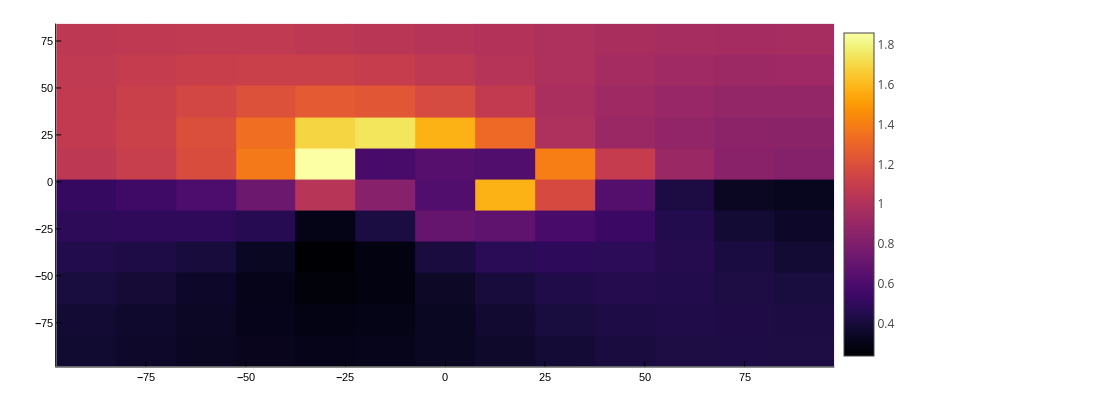

In [38]:
heatmap(xA,yA,imagenE)

In [39]:
ix = 2
#Eouty = [Eout[i][ix]+ EOins[i][ix]  for i ∈ eachindex(Eout)]
Eouty = [Eout[i][ix]  for i ∈ eachindex(Eout)]
Einy = [Ein[i][ix]  for i ∈ eachindex(Ein)]

effy = [Xout Yout norm.(Eouty)./c1;
        Xin Yin norm.(Einy)./c2];

In [40]:
ind = sortperm(effy[:,2])

ogrde = effy[ind,:]


ind2 = sortperm(ogrde[:,1])

ogrde2 = ogrde[ind2,:];

In [41]:
imagenEy = reshape(ogrde2[:,3],(length(yA),length(xA)));

In [42]:
plotly()
surface(xA,yA,imagenEy)

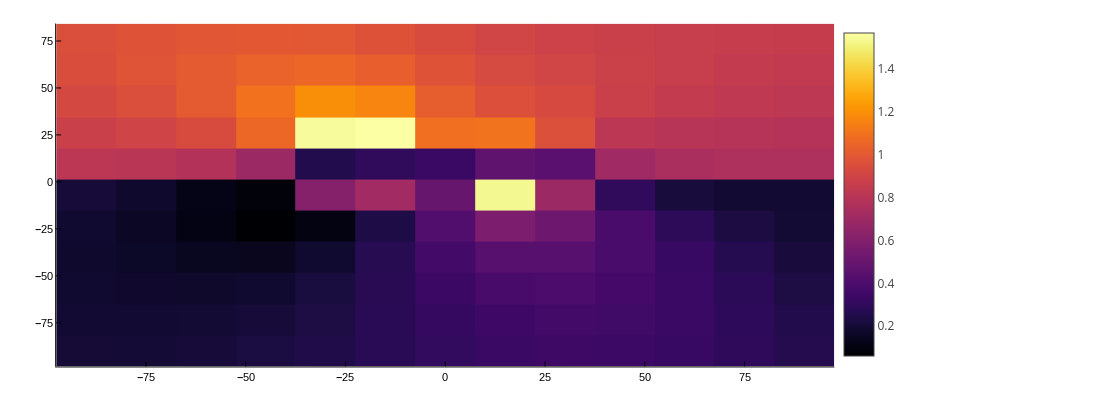

In [43]:
heatmap(xA,yA,imagenEy)

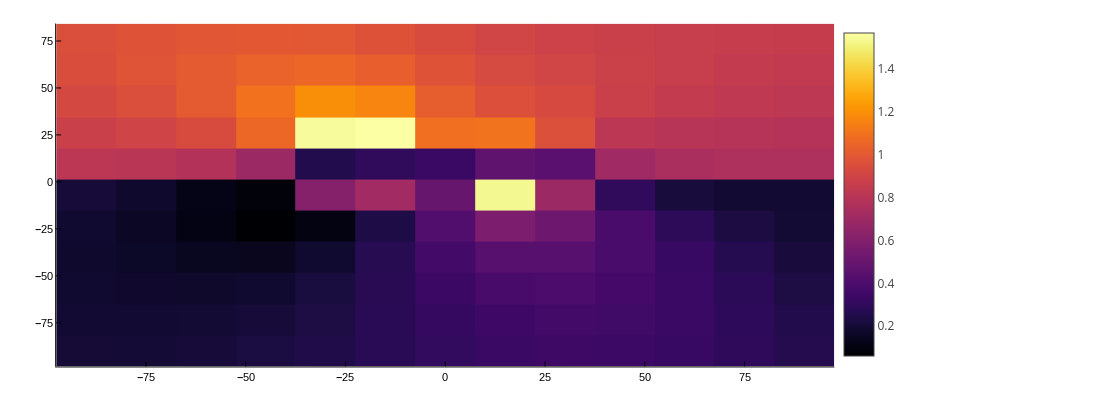

In [44]:
heatmap(xA,yA,imagenEy)